## Procesamiento de Lenguaje Natural

In [82]:
import numpy as np
import pandas as pd
import string
import re

import scipy as sp
from scipy.special import logsumexp
from collections import defaultdict
from itertools import compress
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from gensim import corpora, models
from gensim.models import Phrases
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
import gensim, spacy, logging
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from nltk import bigrams
from nltk import trigrams
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
plt.style.use('ggplot')
mpl.rcParams["figure.dpi"] = 96
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [7]:
esp_stop = stopwords.words('spanish')
esp_stop = esp_stop + ['ser','tener','deber']

In [13]:
import spacy
nlp = spacy.load('es_core_news_sm')

def lemmatizer(text):  
  doc = nlp(text)
  return ' '.join([word.lemma_ for word in doc if word.lemma_ not in esp_stop])

De la base de datos de instituciones correspondiente al proceso constitucional del año 2016, seleccionaremos la institución Fuerzas Armadas. 

In [20]:
instituciones = pd.read_excel('ELA - instituciones.xlsx')

In [21]:
data_ffaa = instituciones[instituciones['categoria'].str.contains('Fuerzas Armadas')]

In [22]:
data_ffaa.shape

(3134, 2)

Realizamos pre procesamiento estándar.

In [27]:
data_ffaa['fundamento'] = data_ffaa['fundamento'].str.lower()
data_ffaa['fundamento'] = data_ffaa['fundamento'].apply(lambda x: re.sub("[0-9]", '', str(x)))
data_ffaa['fundamento'] = data_ffaa['fundamento'].str.translate(str.maketrans(' ', ' ', string.punctuation))
data_ffaa['fundamento'] = data_ffaa['fundamento'].str.strip()
data_ffaa['fundamento'] = data_ffaa['fundamento'].str.replace('\n',' ')

data_ffaa = data_ffaa[[len(x.split( )) >2  for x in data_ffaa.fundamento]]
data_ffaa = data_ffaa.reset_index(drop=True)

In [28]:
data_ffaa.shape

(3023, 2)

Creamos el corpus y lo visualizamos.

In [31]:
corpus = [word_tokenize(lemmatizer(texto)) for texto in data_ffaa.fundamento]

In [ ]:
print(corpus)

A continuación creamos el diccionario, y a través de gensim creamos la matriz DTM.

In [33]:
dict_corpus = corpora.Dictionary(corpus)

In [34]:
dtm_gensim = [dict_corpus.doc2bow(i) for i in corpus]
tfidf = models.TfidfModel(dtm_gensim) # para transformar a tf-idf
dtm_gensim_tfidf = tfidf[dtm_gensim]  # para transformar a tf-idf
dtm_gensim_tfidf  

Creamos el objeto LDA y el modelo LDA, inicialmente usaremos num_topics = 3.

In [35]:
lda_gensim = gensim.models.ldamodel.LdaModel

In [36]:
ldamodel_gensim = lda_gensim(dtm_gensim_tfidf,
                             num_topics = 3,
                             id2word=dict_corpus, 
                             random_state=23, 
                             eval_every=None)

In [38]:
ldamodel_gensim.print_topics(num_words=25)

[(0,
  '0.010*"país" + 0.008*"protección" + 0.008*"fuerza" + 0.007*"armado" + 0.007*"nacional" + 0.007*"proteger" + 0.007*"seguridad" + 0.007*"soberanía" + 0.006*"defensa" + 0.006*"institución" + 0.005*"necesario" + 0.005*"rol" + 0.005*"función" + 0.005*"orden" + 0.005*"recurso" + 0.005*"caso" + 0.005*"poder" + 0.004*"paz" + 0.004*"conflicto" + 0.004*"mantener" + 0.004*"resguardo" + 0.004*"ciudadano" + 0.004*"existir" + 0.004*"mayor" + 0.004*"financiamiento"'),
 (1,
  '0.009*"orden" + 0.009*"seguridad" + 0.007*"resguardar" + 0.007*"fuerza" + 0.007*"armado" + 0.007*"poder" + 0.006*"civil" + 0.006*"público" + 0.006*"ffaa" + 0.005*"él" + 0.005*"pais" + 0.005*"necesario" + 0.005*"soberanía" + 0.005*"país" + 0.005*"constitución" + 0.005*"militar" + 0.005*"servicio" + 0.004*"garantizar" + 0.004*"nacional" + 0.004*"mismo" + 0.004*"interno" + 0.004*"institución" + 0.004*"haber" + 0.004*"defensa" + 0.004*"velar"'),
 (2,
  '0.010*"ley" + 0.009*"soberanía" + 0.008*"poder" + 0.008*"cobre" + 0.008*

También podemos crear la matriz de tópicos por palabras.

In [39]:
df_topic_term = pd.DataFrame(ldamodel_gensim.get_topics(), columns=ldamodel_gensim.id2word.values(), 
                             index=[f'topic{i}' for i in range(ldamodel_gensim.num_topics)])

In [40]:
df_topic_term.head()

,mantener,orden,respeto,seguridad,civil,cobre,fin,financiamiento,gasto,justicia,...,inseguridad,chilenojusticia,agresor,sólido,acordamos,cosén,reservo,constar,aquejar,numeroso
topic0,0.004063,0.005071,0.001364,0.006951,0.002938,0.002826,0.001215,0.003627,0.002994,0.001955,...,0.000095,0.000377,0.000104,0.000104,0.000101,0.000106,0.000103,0.000441,0.000100,0.000100
topic1,0.002533,0.008955,0.001545,0.008691,0.006116,0.002690,0.001200,0.003273,0.002201,0.003081,...,0.000169,0.000085,0.000089,0.000089,0.000087,0.000336,0.000089,0.000085,0.000259,0.000259
topic2,0.002394,0.003037,0.000998,0.005199,0.007682,0.008123,0.003330,0.004141,0.002815,0.003560,...,0.000193,0.000107,0.000398,0.000398,0.000464,0.000108,0.000498,0.000112,0.000099,0.000099


Podemos observar las palabras por cada tópico, una forma distinta al método anterior, pero con el mismo resultado.

In [42]:
df_topic_term.loc['topic0'].sort_values(ascending=False)

país          0.010095
protección    0.007967
fuerza        0.007965
armado        0.007475
nacional      0.007354
                ...   
consignado    0.000090
mujer         0.000090
involucrar    0.000090
negar         0.000090
violente      0.000090
Name: topic0, Length: 3180, dtype: float32

In [43]:
df_topic_term.loc['topic1'].sort_values(ascending=False)

orden             0.008955
seguridad         0.008691
resguardar        0.007406
fuerza            0.007119
armado            0.006724
                    ...   
unificación       0.000077
innovación        0.000077
•ff               0.000077
adiestramiento    0.000077
redestinar        0.000077
Name: topic1, Length: 3180, dtype: float32

In [44]:
df_topic_term.loc['topic2'].sort_values(ascending=False)

ley            0.009620
soberanía      0.008659
poder          0.008455
cobre          0.008123
fundamental    0.008087
                 ...   
bar            0.000093
encasillar     0.000093
pesar          0.000093
escaneado      0.000093
versión        0.000093
Name: topic2, Length: 3180, dtype: float32

Podemos observar la distribución de tópicos por documento.

In [45]:
ldamodel_gensim.get_document_topics(dtm_gensim_tfidf[1])

[(0, 0.104478784), (1, 0.09354839), (2, 0.8019728)]

In [ ]:
cont = 0
for i in ldamodel_gensim[dtm_gensim_tfidf]:
  print('doc ',cont , ': ',i)
  cont +=1

También podemos extraer los documentos representativos de un tópico dado.

In [47]:
def get_max(doc):
        idx,l = zip(*doc)
        return idx[np.argmax(l)] , l[np.argmax(l)] 

asd = [get_max(doc) for doc in ldamodel_gensim[dtm_gensim_tfidf]]
df_asd = pd.DataFrame(asd, columns =['tópico', 'prop'])
df_asd['doc'] = df_asd.index

In [48]:
df_asd[df_asd.tópico==1].sort_values('prop',ascending=False).head(10)

,tópico,prop,doc
2644,1,0.887614,2644
1906,1,0.873158,1906
1815,1,0.870886,1815
2609,1,0.870454,2609
2575,1,0.868386,2575
2518,1,0.868133,2518
887,1,0.867819,887
556,1,0.866122,556
1372,1,0.865384,1372
2492,1,0.864168,2492


In [50]:
data_ffaa.fundamento[2644]

'la incorporación de esta institución en la constitución no debe convertirse en una discusión que juzgue su rol histórico en particular tras el golpe de estado de  si las fuerzas armadas se incluyen como institución en la constitución es necesario precisar que el rol de éstas no es el de garante del orden constitucional su rol entonces se restringe a la defensa del país frente a una agresión externa jamás será legítima su actuación en contra del pueblo soberano las fuerzas armadas nunca podrán estar al servicio del terrorismo de estado'

Siguiente paso para el diagnóstico, calculamos las palabras Frex: palabra frecuentes y exclusivas.

In [53]:
w=0.5    # 0 equivale a beta

def ecdf(arr):
    """Calculate the ECDF values for all elements in a 1D array.  empirical cumulative ditribution function """ 
    return sp.stats.rankdata(arr, method='max') / arr.size   


log_beta = np.log(ldamodel_gensim.get_topics())
log_exclusivity = log_beta - logsumexp(log_beta, axis=0)

exclusivity_ecdf = np.apply_along_axis(ecdf, 1, log_exclusivity)
freq_ecdf = np.apply_along_axis(ecdf, 1, log_beta)
out_frex = 1. / (w / exclusivity_ecdf + (1 - w) / freq_ecdf)
out_frex

array([[0.8824509 , 0.63261117, 0.75741738, ..., 0.90699141, 0.28825472,
        0.28825472],
       [0.68740778, 0.92549417, 0.83253197, ..., 0.1147302 , 0.81044197,
        0.81044197],
       [0.50642793, 0.21622107, 0.48042264, ..., 0.18306673, 0.26911968,
        0.26911968]])

In [54]:
df_topic_frex = pd.DataFrame(out_frex, columns=ldamodel_gensim.id2word.values(), 
                             index=[f'topic{i}' for i in range(ldamodel_gensim.num_topics)])

In [55]:
df_topic_frex.loc['topic1'].sort_values(ascending=False)

velar             0.994962
público           0.993852
pais              0.991481
publico           0.990696
mismo             0.986899
                    ...   
pacífico          0.001883
adiestramiento    0.001256
garantía          0.001256
mantención        0.000629
redestinar        0.000629
Name: topic1, Length: 3180, dtype: float64

Calculamos coherencia semántica y Perpléxity.

In [57]:
coherence_model_lda = CoherenceModel(model=ldamodel_gensim, texts=corpus, dictionary=dict_corpus, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

# Compute Perplexity
print('\nPerplexity: ', ldamodel_gensim.log_perplexity(dtm_gensim_tfidf))


Coherence Score:  0.31773060872665204

Perplexity:  -8.081755213537363


Dividemos nuestro dataset en set de estrenamiento y test, aplicando un método de optimización del modelo, para obtener una gráfica que nos indique el número óptimo de tópicos para reevaluar el modelo.

In [59]:
X_train, X_test = train_test_split(corpus, train_size=0.9, test_size=0.1, random_state=1)

dict_corpus_train = corpora.Dictionary(X_train)
dtm_gensim_train = [dict_corpus_train.doc2bow(i) for i in X_train]
tfidf_train = models.TfidfModel(dtm_gensim_train) 
dtm_gensim_tfidf_train = tfidf[dtm_gensim_train]  

dict_corpus_test = corpora.Dictionary(X_test)
dtm_gensim_test = [dict_corpus_test.doc2bow(i) for i in X_test]
tfidf_test = models.TfidfModel(dtm_gensim_test) 
dtm_gensim_tfidf_test = tfidf[dtm_gensim_test]  

n_topics = range(3,20)

coherence_lda = []
perplexity = []
for nr_topics in n_topics:
    ldamodel2 = gensim.models.LdaModel(dtm_gensim_tfidf_train, id2word=dict_corpus_train, num_topics=nr_topics, random_state=42)
    perplexity.append(2**(-1*ldamodel2.log_perplexity(dtm_gensim_tfidf_test)))
    ldamodel3= lda_gensim(dtm_gensim,num_topics = nr_topics ,id2word=dict_corpus, random_state=0, eval_every=None)
    coherence_model_lda = CoherenceModel(model=ldamodel3, texts=corpus, dictionary=dict_corpus, coherence='c_v')
    coherence_lda.append(coherence_model_lda.get_coherence())

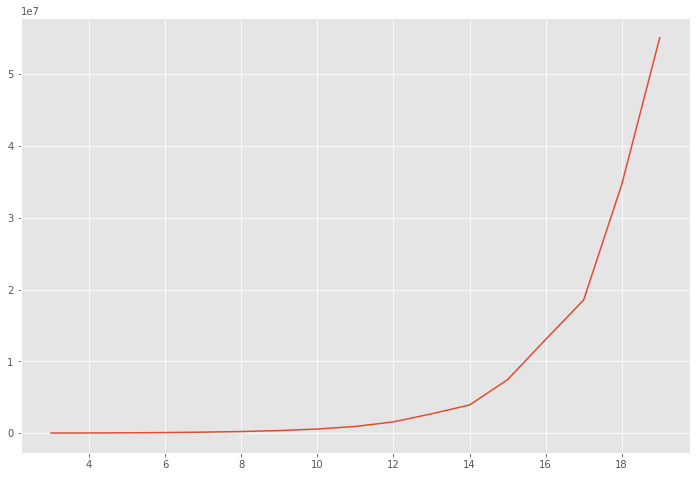

In [92]:
plt.figure(figsize=(12, 8))
plt.plot(n_topics, perplexity)

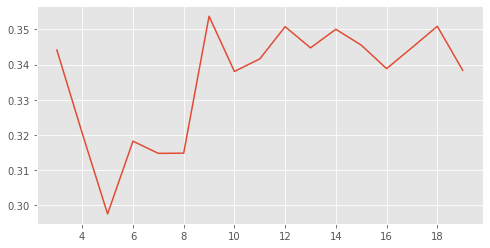

In [60]:
plt.figure(figsize=(8, 4))
plt.plot(n_topics, coherence_lda)

Vemos que el punto más alto es 9 para coherencia semántica, por lo que volvemos a correr el modelo ingresando este valor.

In [61]:
ldamodel_gensim = lda_gensim(dtm_gensim_tfidf,
                             num_topics = 9,
                             id2word=dict_corpus, 
                             random_state=23, 
                             eval_every=None)

Y volvemos a visulizar las palabras con mayor indicador por tópico.

In [63]:
ldamodel_gensim.print_topics(num_words=20)

[(0,
  '0.007*"ciudadano" + 0.007*"rol" + 0.007*"soberanía" + 0.007*"paz" + 0.007*"financiamiento" + 0.006*"fuerza" + 0.006*"orden" + 0.006*"armado" + 0.006*"tiempo" + 0.006*"cumplir" + 0.006*"único" + 0.006*"país" + 0.005*"revisar" + 0.005*"proteger" + 0.005*"pueblo" + 0.005*"mantener" + 0.005*"garantía" + 0.005*"función" + 0.005*"poder" + 0.005*"ffaa"'),
 (1,
  '0.008*"seguridad" + 0.008*"fuerza" + 0.008*"mismo" + 0.007*"armado" + 0.007*"velar" + 0.006*"garantizar" + 0.006*"él" + 0.006*"orden" + 0.006*"pais" + 0.006*"constitución" + 0.006*"poder" + 0.005*"funcionario" + 0.005*"estructura" + 0.005*"eliminar" + 0.005*"ciudadanía" + 0.004*"ffaa" + 0.004*"derecho" + 0.004*"público" + 0.004*"democratizar" + 0.004*"tribunal"'),
 (2,
  '0.015*"ley" + 0.012*"cobre" + 0.011*"reservado" + 0.009*"eliminar" + 0.007*"ffaa" + 0.007*"obediente" + 0.007*"civil" + 0.007*"presupuesto" + 0.006*"poder" + 0.006*"fuerza" + 0.006*"armado" + 0.006*"país" + 0.005*"tribunal" + 0.005*"contraloría" + 0.005*"tra

In [64]:
df_topic_term = pd.DataFrame(ldamodel_gensim.get_topics(), columns=ldamodel_gensim.id2word.values(), 
                             index=[f'topic{i}' for i in range(ldamodel_gensim.num_topics)])

In [66]:
df_topic_term.head(9)

,mantener,orden,respeto,seguridad,civil,cobre,fin,financiamiento,gasto,justicia,...,inseguridad,chilenojusticia,agresor,sólido,acordamos,cosén,reservo,constar,aquejar,numeroso
topic0,0.004860,0.006104,0.002224,0.004321,0.003092,0.004205,0.001006,0.006653,0.000869,0.002311,...,0.000093,0.000093,0.000093,0.000093,0.000093,0.000093,0.000093,0.000093,0.000093,0.000093
topic1,0.002006,0.006073,0.002651,0.007987,0.004232,0.004210,0.002178,0.002797,0.001755,0.001915,...,0.000129,0.000102,0.000102,0.000102,0.000102,0.000102,0.000102,0.000102,0.000336,0.000336
topic2,0.001281,0.002821,0.000095,0.002375,0.006895,0.011967,0.002972,0.004083,0.004279,0.003397,...,0.000095,0.000167,0.000095,0.000095,0.000095,0.000095,0.000426,0.000095,0.000095,0.000095
topic3,0.000478,0.005628,0.000358,0.003268,0.009550,0.001636,0.001832,0.002633,0.001720,0.004067,...,0.000173,0.000090,0.000090,0.000090,0.000090,0.000090,0.000090,0.000090,0.000090,0.000090
topic4,0.003091,0.001597,0.000948,0.007346,0.008846,0.002935,0.000622,0.001129,0.001281,0.002528,...,0.000094,0.000094,0.000094,0.000094,0.000094,0.000094,0.000094,0.000411,0.000094,0.000094
topic5,0.005001,0.008113,0.001379,0.012809,0.004286,0.002470,0.000550,0.002145,0.004032,0.001003,...,0.000094,0.000258,0.000094,0.000094,0.000094,0.000094,0.000094,0.000094,0.000094,0.000094
topic6,0.003667,0.010656,0.004038,0.006515,0.002337,0.007179,0.007324,0.002430,0.006224,0.003857,...,0.000111,0.000111,0.000111,0.000111,0.000111,0.000111,0.000111,0.000111,0.000111,0.000111
topic7,0.005868,0.010240,0.001339,0.017024,0.003211,0.002109,0.001356,0.005882,0.002359,0.000957,...,0.000099,0.000072,0.000072,0.000072,0.000072,0.000072,0.000072,0.000072,0.000072,0.000072
topic8,0.001467,0.004187,0.000273,0.003147,0.008981,0.005653,0.001000,0.005165,0.002916,0.006429,...,0.000071,0.000071,0.000237,0.000237,0.000281,0.000215,0.000071,0.000071,0.000071,0.000071


In [67]:
ldamodel_gensim.get_document_topics(dtm_gensim_tfidf[1])

[(0, 0.027331235),
 (1, 0.027331535),
 (2, 0.027347302),
 (3, 0.02733429),
 (4, 0.027328247),
 (5, 0.027328506),
 (6, 0.2678871),
 (7, 0.027330967),
 (8, 0.54078084)]

In [68]:
def get_max(doc):
        idx,l = zip(*doc)
        return idx[np.argmax(l)] , l[np.argmax(l)] 

asd = [get_max(doc) for doc in ldamodel_gensim[dtm_gensim_tfidf]]
df_asd = pd.DataFrame(asd, columns =['tópico', 'prop'])
df_asd['doc'] = df_asd.index

In [69]:
df_asd[df_asd.tópico==1].sort_values('prop',ascending=False).head(10)

,tópico,prop,doc
575,1,0.832163,575
1515,1,0.827618,1515
72,1,0.826636,72
1953,1,0.821402,1953
2587,1,0.816216,2587
1006,1,0.815271,1006
182,1,0.809258,182
1369,1,0.809084,1369
277,1,0.807209,277
1914,1,0.806406,1914


In [70]:
w=0.5    # 0 equivale a beta

def ecdf(arr):
    """Calculate the ECDF values for all elements in a 1D array.  empirical cumulative ditribution function """ 
    return sp.stats.rankdata(arr, method='max') / arr.size   


log_beta = np.log(ldamodel_gensim.get_topics())
log_exclusivity = log_beta - logsumexp(log_beta, axis=0)

exclusivity_ecdf = np.apply_along_axis(ecdf, 1, log_exclusivity)
freq_ecdf = np.apply_along_axis(ecdf, 1, log_beta)
out_frex = 1. / (w / exclusivity_ecdf + (1 - w) / freq_ecdf)
out_frex

array([[0.92581337, 0.89622248, 0.91251696, ..., 0.41711313, 0.40267142,
        0.40267142],
       [0.40312512, 0.83012154, 0.92553879, ..., 0.42509466, 0.89893028,
        0.89893028],
       [0.24902827, 0.28725302, 0.00188422, ..., 0.4170481 , 0.39966549,
        0.39966549],
       ...,
       [0.91124148, 0.93946973, 0.9667508 , ..., 0.44523374, 0.43065894,
        0.43065894],
       [0.95304636, 0.93757602, 0.8658191 , ..., 0.38860128, 0.36521065,
        0.36521065],
       [0.36154248, 0.77820935, 0.08081929, ..., 0.36198418, 0.3382494 ,
        0.3382494 ]])

In [71]:
df_topic_frex = pd.DataFrame(out_frex, columns=ldamodel_gensim.id2word.values(), 
                             index=[f'topic{i}' for i in range(ldamodel_gensim.num_topics)])

In [76]:
df_topic_frex.loc['topic1'].sort_values(ascending=False).head(15)

relevancia      0.995895
asumir          0.995105
salvaguardar    0.994314
aparte          0.992413
tranquilidad    0.991963
corrupción      0.991640
utilidad        0.991151
mundo           0.989870
clasismo        0.989533
gran            0.989145
electo          0.988743
imponer         0.988316
funcionario     0.987977
según           0.986155
pib             0.985873
Name: topic1, dtype: float64

A modo de comparación con el modelo anterior, aplicamos el mismo método anterior para obtener los valores de coherencia semántica y prepléxity.

In [73]:
coherence_model_lda = CoherenceModel(model=ldamodel_gensim, texts=corpus, dictionary=dict_corpus, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

# Compute Perplexity
print('\nPerplexity: ', ldamodel_gensim.log_perplexity(dtm_gensim_tfidf))


Coherence Score:  0.3389641019459712

Perplexity:  -9.24238998940297


Vemos que el Coherence Score aumenta y Preplexity disminuye, lo que significa que mejoró el modelo con los ajustes realizados.

A continuación procedemos a construir los Wordclouds, para la nube de una palabra usaremos sustantivos sin lemmatizar.

In [80]:
toks = []
toks_noun = []
for ix in range(data_ffaa.shape[0]):
    
    ### sin lematizar, filtrando por sustantivos
    doc = nlp(data_ffaa.fundamento[ix])
    tokens = [token.text for token in doc]
    tags = [token.tag_ for token in doc]
    tokens_noun =  list(compress(tokens, [True if tag=='NOUN' else False for tag in tags])) 
    toks_noun.extend(tokens_noun)

df_tokens_noun = pd.DataFrame(list(zip(toks_noun)), columns =['token']) 
tokens_count_noun = df_tokens_noun['token'].value_counts().rename_axis('token').reset_index(name='counts')
tokens_count_noun = tokens_count_noun[tokens_count_noun.counts>3]

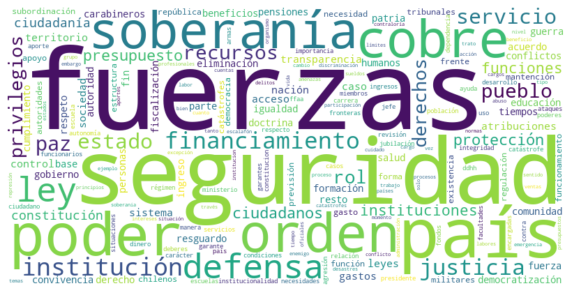

In [83]:
data = dict(zip(tokens_count_noun['token'].tolist(), tokens_count_noun['counts'].tolist()))
wc = WordCloud(background_color='white',width=800, height=400, max_words=200).generate_from_frequencies(data)

plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Para bigramas utilizaremos sustantivo y adjetivo, sin eliminar stopwords y sin lemmatizar.

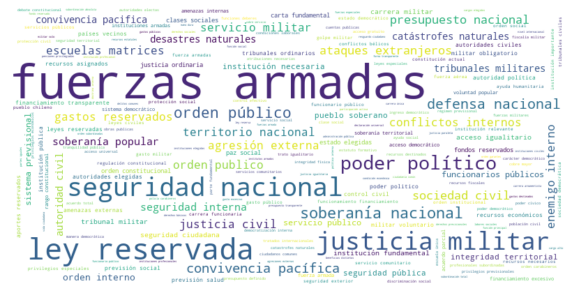

In [88]:
bigramas = []
for ix in range(data_ffaa.shape[0]):
    mytext = data_ffaa.fundamento[ix]
    tokens = word_tokenize(mytext)
    if len(tokens)>1:
        bi_tokens = [' '.join(x) for x in list(bigrams(tokens))]
        for bi in bi_tokens:
          doc = nlp(bi)
          tokens = [token.text for token in doc]
          tags = [token.tag_ for token in doc]
          if tags == ['NOUN', 'ADJ']:
            bigramas.append(bi)

bigram = pd.DataFrame(list(zip(bigramas)), columns =['ngram']) 
bigram_count_tag = bigram['ngram'].value_counts().rename_axis('ngram').reset_index(name='counts')
  
data = dict(zip(bigram_count_tag['ngram'].tolist(), bigram_count_tag['counts'].tolist()))
wc = WordCloud(background_color='white',width=800, height=400, max_words=200).generate_from_frequencies(data)

plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Para trigramas, con etiqueta gramatical, utilizamos la combinación sustantivo, preposición, sustantivo.

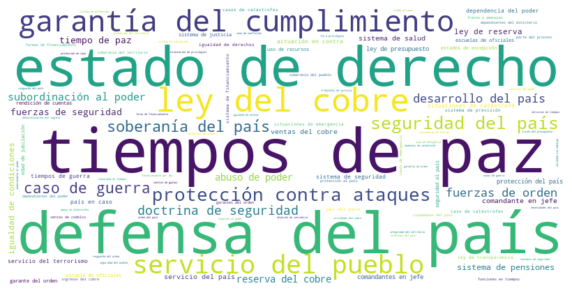

In [85]:
trigramas = []
for ix in range(data_ffaa.shape[0]):
    mytext = data_ffaa.fundamento[ix]
    tokens = word_tokenize(mytext)
    if len(tokens)>1:
        tri_tokens = [' '.join(x) for x in list(trigrams(tokens))]
        for tri in tri_tokens:
          doc = nlp(tri)
          tokens = [token.text for token in doc]
          tags = [token.tag_ for token in doc]
          if tags == ['NOUN', 'ADP', 'NOUN']:
            trigramos.append(tri)

trigram = pd.DataFrame(list(zip(trigramos)), columns =['ngram']) 
trigram_count_tag = trigram['ngram'].value_counts().rename_axis('ngram').reset_index(name='counts')
  
data = dict(zip(trigram_count_tag['ngram'].tolist(), trigram_count_tag['counts'].tolist()))
wc = WordCloud(background_color='white',width=800, height=400, max_words=200).generate_from_frequencies(data)

plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()